In [1]:
from sklearn import preprocessing
import numpy as np
import pandas as pd

df = pd.read_csv("nuclear/data.csv")

In [2]:
df_2d= df.drop(columns = ['AP', 'RH', "PE"])
# df_2d = df.drop(columns = ['z'])


In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_2d = scaler.fit_transform(df_2d)

# df_2d = preprocessing.scale(df_2d)

In [4]:
import matplotlib.pyplot as plt

# df_2d = df_2d[:10000,]

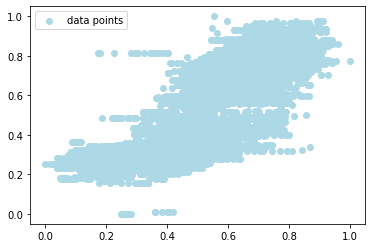

In [5]:

# df_2d=  df_2d[:10000,]
fig,ax = plt.subplots(1)


x = df_2d[:,0]
y = df_2d[:,1]

ax.scatter(x, y, color='lightblue', label='data points')
ax.legend(loc='upper left')


In [6]:
num_elements = 5000
minX = min(x)
maxX = max(x)
Q1 = np.random.uniform(minX, maxX, num_elements)

minY = min(y)
maxY = max(y)
Q2 = np.random.uniform(minY, maxY, num_elements)
# fig2 = plt.figure()
# ax2 = fig2.add_subplot()
# plt.plot(Q1, Q2, 'o', c="red")
# plt.show()

In [7]:
# L is half the length of the rectangle
maxSize  =max(maxX, maxY)/3
L = np.random.uniform(low = 0, high= maxSize/2, size = num_elements)


In [8]:
query_lst = []
for Q1_, Q2_, L_ in zip(Q1, Q2, L):
    query = [Q1_, Q2_, L_, L_]
    query_lst.append(query)

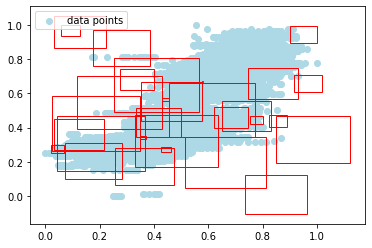

In [9]:
import matplotlib.patches as patches

fig,ax = plt.subplots(1)
# x = df_2d[:,0]
# y = df_2d[:,1]

ax.scatter(x, y, color='lightblue', label='data points')
ax.legend(loc='upper left')


for query in query_lst [:30]:
    # Leftmost point of square
    a,b = query[0] - query[2], query[1] - query[3]
    # Assumes Square
    length = query[3] * 2

    rect = patches.Rectangle((a,b),length, length, edgecolor='r', fill=False, zorder=2, label = "query range")
    # currentAxis = plt.gca()
    ax.add_patch(rect)


plt.show()


In [10]:
def inRange (Q, X1, X2):
    Q1 = Q[0]
    Q2 = Q[1]
    L1 = Q[2]
    L2 = Q[3]

    if (Q1 - L1 <= X1 and X1 <= Q1 +L1) and (Q2 - L2 <= X2 and X2 <= Q2 +L2):
        return True
    return False

In [11]:
from scipy.stats import pearsonr
import math
import statistics
from sklearn.linear_model import LinearRegression
def getResults(query_lst, X1, X2):
    results = []
    for _Q in query_lst:
        count = 0
        valid_X1_lst =[]
        valid_X2_lst =[]
        df = []
        for _X1, _X2 in zip(X1, X2):
            if inRange(_Q, _X1, _X2):
                count+=1
                valid_X1_lst.append(_X1)
                valid_X2_lst.append(_X2)
                df.append([_X1, _X2])
        
        if count >=2:
            Q_dict = {
                'query': _Q, 
                'count': count,
                "x1_avr": np.mean(valid_X1_lst), 
                "x2_avr": np.mean(valid_X2_lst), 
                'pearson': pearsonr(valid_X1_lst, valid_X2_lst)[0],
                'X1_reg_coef':  statistics.mean(LinearRegression().fit(df,valid_X1_lst).coef_),
                'X2_reg_coef':  statistics.mean(LinearRegression().fit(df,valid_X2_lst).coef_)
            }
            add =True
            for v in Q_dict.values():
                if isinstance(v, list)!=True: 
                
                    if math.isnan(v):
                        add =False
                
            if add: 
                results.append(Q_dict)

    return results

    

In [12]:
from sklearn.model_selection import train_test_split


def get_training_data(y_parameter):
    data = getResults(query_lst, x ,y)
    queries = [query_dict["query"] for query_dict in data]
    results = [query_dict[y_parameter] for query_dict in data]
    return queries, results, data

In [13]:
from sklearn.model_selection import train_test_split


def get_training_data_split(y_parameter):
    data = getResults(query_lst, x ,y)
    queries = [query_dict["query"] for query_dict in data]
    results = [query_dict[y_parameter] for query_dict in data]
    train_data, validation_data, train_labels, validation_labels = train_test_split(queries, results, test_size=0.3)

    print('Training set contains {:d} rows.'.format(len(train_data)))
    print('Vadlidation set contains {:d} rows.'.format(len(validation_data)))

    return train_data, train_labels, validation_data, validation_labels

In [14]:
train_data, train_labels, rawData = get_training_data("count")

In [15]:
td,tl,vd,vl  = get_training_data_split("count")

Training set contains 2170 rows.
Vadlidation set contains 931 rows.


In [16]:
from sklearn.metrics import make_scorer
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
smape_scorer=  make_scorer(smape, greater_is_better=False)

In [17]:
smape(np.array([1]), np.array([2]))

66.66666666666666

In [18]:

# import sklearn.metrics as metrics
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score
# from numpy import mean

# def globalModelPrediction2(model, name):
#     cv = KFold(n_splits=10, random_state=1, shuffle=True)

#     scores_smape = cross_val_score(model, train_data, train_labels, scoring=smape_scorer, cv=cv, n_jobs=-1)
 
#     print("Symmetric Mean Absolute Percentage Error for " + name + ": " + str(int(mean(np.absolute(scores_smape))))+"%")

#     scores_mae = cross_val_score(model, train_data, train_labels, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
 
#     print("Mean Absolute Error for " + name + ": " + str(int(mean(np.absolute(scores_mae)))))

#     scores_r2 = cross_val_score(model, train_data, train_labels, scoring='r2', cv=cv, n_jobs=-1)
 
#     print("R2 Score for " + name + ": " + str(round(mean(scores_r2), 2)))

In [19]:

import sklearn.metrics as metrics
from numpy import mean
import time

def globalModelPrediction(model, name):
    start_time = time.time()
    model.fit(td,tl)
    vp = model.predict(vd)
    print(type(vp))
    print("- %.3f seconds -" % (time.time() - start_time))
    print('Symmetric Mean Absolute Percentage Error for %s: %.0f' % (name, smape(vl, vp))+'%')
    print('Root Mean Squared Error for %s: %.0f' % (name, metrics.mean_squared_error(vl, vp, squared=False)))
    print('R2 Score for %s: %.2f' % (name, metrics.r2_score(vl, vp)))
    
    

In [20]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

globalModelPrediction(lr, "Linear Regression")

<class 'numpy.ndarray'>
- 0.005 seconds -
Symmetric Mean Absolute Percentage Error for Linear Regression: 102%
Root Mean Squared Error for Linear Regression: 631
R2 Score for Linear Regression: 0.24


In [21]:
from sklearn import svm
globalModelPrediction(svm.SVR(), "Support Vector Regression")

<class 'numpy.ndarray'>
- 0.215 seconds -
Symmetric Mean Absolute Percentage Error for Support Vector Regression: 109%
Root Mean Squared Error for Support Vector Regression: 761
R2 Score for Support Vector Regression: -0.10


In [22]:
from sklearn.neighbors import KNeighborsRegressor
globalModelPrediction(KNeighborsRegressor(), "K Nearest Neighbors Regression")


<class 'numpy.ndarray'>
- 0.008 seconds -
Symmetric Mean Absolute Percentage Error for K Nearest Neighbors Regression: 37%
Root Mean Squared Error for K Nearest Neighbors Regression: 132
R2 Score for K Nearest Neighbors Regression: 0.97


In [23]:
from sklearn.gaussian_process import GaussianProcessRegressor
globalModelPrediction(GaussianProcessRegressor(), "Gaussian Process Regression")

<class 'numpy.ndarray'>
- 0.456 seconds -
Symmetric Mean Absolute Percentage Error for Gaussian Process Regression: 59%
Root Mean Squared Error for Gaussian Process Regression: 123
R2 Score for Gaussian Process Regression: 0.97


In [24]:
from sklearn import tree
globalModelPrediction(tree.DecisionTreeRegressor(), "Decision Tree Regression")


<class 'numpy.ndarray'>
- 0.012 seconds -
Symmetric Mean Absolute Percentage Error for Decision Tree Regression: 47%
Root Mean Squared Error for Decision Tree Regression: 233
R2 Score for Decision Tree Regression: 0.90


In [25]:
from sklearn.ensemble import AdaBoostRegressor
globalModelPrediction(AdaBoostRegressor(), "Ada Boost Regression")


<class 'numpy.ndarray'>
- 0.056 seconds -
Symmetric Mean Absolute Percentage Error for Ada Boost Regression: 98%
Root Mean Squared Error for Ada Boost Regression: 607
R2 Score for Ada Boost Regression: 0.30


In [26]:
from sklearn.linear_model import ElasticNet
globalModelPrediction( ElasticNet(), "ElasticNet Regression")

<class 'numpy.ndarray'>
- 0.008 seconds -
Symmetric Mean Absolute Percentage Error for ElasticNet Regression: 113%
Root Mean Squared Error for ElasticNet Regression: 724
R2 Score for ElasticNet Regression: 0.00


In [27]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import copy
import time
def build_cluster_data(all_data, train_data, train_labels, model, k=3):
    visualizer = KElbowVisualizer(KMeans(), k=(1,100))
    visualizer.fit(np.array(all_data))
    k = visualizer.elbow_value_
    cluster_data = {i: {'data': [], 'labels': []} for i in range(k)}
    data_points ={}
    data_points['all'] = all_data 
    data_points['td'] = train_data
    data_points['tl'] = train_labels
    kmeans = KMeans(n_clusters=k).fit(all_data)
    for query, label, cluster_id in zip(train_data, train_labels, kmeans.predict(train_data)):
        cluster_data[cluster_id]['data'].append(query)
        cluster_data[cluster_id]['labels'].append(label)
       
    for cluster in cluster_data.values():
        m = copy.deepcopy(model)
        start_time = time.time()
        m.fit(cluster['data'], cluster['labels'])
        fit_time = time.time() - start_time
        cluster["model"] = m

    return cluster_data, kmeans, data_points, k, fit_time

In [28]:
import sklearn.metrics as metrics
from numpy import mean
import time
def validate_data(cluster_data, validation_data, validation_labels, kmeans):
    validation_cluster_data = {i: {'data': [], 'labels': []} for i in range(k)}
    predicted_clusters  = kmeans.predict(validation_data)
    for query, label, cluster_id in zip(validation_data, validation_labels, predicted_clusters):
        validation_cluster_data[cluster_id]['data'].append(query)
        validation_cluster_data[cluster_id]['labels'].append(label)

    rmse_list = []
    r2_list = []
    smape_list = []
    for cluster_key, cluster in zip (validation_cluster_data.keys(), validation_cluster_data.values()):
        cvd =  validation_cluster_data[cluster_key]['data']
        cvl =  validation_cluster_data[cluster_key]['labels']
        model = cluster_data[cluster_key]['model']
        start_time = time.time()
        cvp = model.predict(cvd)
        
        pred_time = time.time() - start_time
        smape_list.append(smape(cvl, cvp))
        rmse_list.append( metrics.mean_squared_error(cvl, cvp, squared=False))
        r2_list.append(metrics.r2_score(cvl, cvp))

    print("Symmetric Mean Absolute Percentage Error:"  + str(int(mean(smape_list)))+"%")

    print("Root Mean Squared Error: " + str(int(mean(rmse_list))))

    print("R2 Score: " + str(round(mean(r2_list), 2)))
    return validation_cluster_data, int(mean(smape_list)), pred_time

In [29]:
def print_clusters(cluster_data):
    colors = ['red', "blue", 'black', 'green']
    fig,ax = plt.subplots(1)

    for label, cluster, color  in zip(cluster_data.keys(), cluster_data.values(), colors):
        x = [i[0] for i in cluster['data']]
        y = [i[1] for i in cluster['data']]   
        ax.scatter(x, y, color=color, label='Cluster: ' + str(label))
        ax.legend(loc='upper left')
    a = [i[0] for i in kmeans.cluster_centers_]
    b = [i[1] for i in kmeans.cluster_centers_]
    ax.scatter(a, b, color="yellow")

Symmetric Mean Absolute Percentage Error:37%
Root Mean Squared Error: 55
R2 Score: 0.99


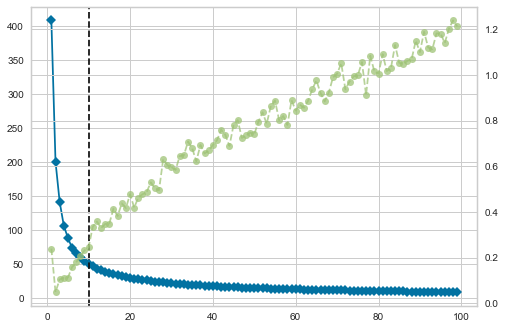

In [30]:
import time

model =  GaussianProcessRegressor()
# for i in range(1,60):
#     cluster_data, kmeans, k,bh = build_cluster_data(train_data, td, tl, model, k=i)
#     validation_clusters, num,we = validate_data(cluster_data, vd, vl, kmeans)
#     print((i, num))
# model_lst = [ LinearRegression(), svm.SVR(), ElasticNet(), KNeighborsRegressor(),GaussianProcessRegressor(), tree.DecisionTreeRegressor(), AdaBoostRegressor() ]
# for model in model_lst:
#     cluster_data, kmeans, k, fit_time = build_cluster_data(train_data, td, tl, model)
#     validation_clusters, num, pred_time = validate_data(cluster_data, vd, vl, kmeans)
#     print("- %.3f seconds -" % (fit_time+pred_time))
cluster_data, kmeans, data_points, k,ngd = build_cluster_data(train_data, td, tl, model)
validation_clusters, num, fdxsd = validate_data(cluster_data, vd, vl, kmeans)

In [31]:
def update_clusters(model, new_queries):
    new_train_data = train_data + new_queries
    cluster_data, kmeans, k, tyr = build_cluster_data(new_train_data, td, tl, model)
    return cluster_data, kmeans, k

In [32]:
def predict_query(queries, cluster_data=cluster_data, kmeans=kmeans):
    # cluster_data, kmeans, k = update_clusters(model, queries)
    # cluster_data, kmeans, k, fit_time = build_cluster_data(train_data, td, tl, model)
    predicted_clusters  = kmeans.predict(queries)
    results = []
    for key, query in zip(predicted_clusters, queries):
        predicted_label = cluster_data[key]['model'].predict([query])[0]
        results.append(int(predicted_label))
    return results

In [33]:
from scipy.spatial import distance
def queryDistance(q1, q2):
    return distance.euclidean(q1, q2)

In [34]:
def shouldExecute(query, cluster_data=cluster_data, kmeans=kmeans):
    dist_to_centre_lst = []
    cluster_id = kmeans.predict([query])[0]
    cluster_centre = kmeans.cluster_centers_[cluster_id]
    dist_from_centre = queryDistance(query, cluster_centre)
    for query in cluster_data[cluster_id]['data']:
        dist_to_centre_lst.append(queryDistance(query, cluster_centre))
    return dist_from_centre > np.mean(dist_to_centre_lst)
       


In [35]:
def update_clusters(cluster_data, queries, labels):
    new_train_data = cluster_data['all'] + queries
    td = cluster_data['td'] + queries
    tl = cluster_data['tl'] + labels
    cluster_data, kmeans, data_points, k, tyr = build_cluster_data(new_train_data, td, tl, model)
    return cluster_data, kmeans, data_points

Queries Executed: 48
Symmetric Mean Absolute Percentage Error: 22
Queries Executed: 52
Symmetric Mean Absolute Percentage Error: 39
Queries Executed: 46
Symmetric Mean Absolute Percentage Error: 22
Queries Executed: 53
Symmetric Mean Absolute Percentage Error: 31
Queries Executed: 44
Symmetric Mean Absolute Percentage Error: 30
Queries Executed: 50
Symmetric Mean Absolute Percentage Error: 29
Queries Executed: 52
Symmetric Mean Absolute Percentage Error: 18
Queries Executed: 55
Symmetric Mean Absolute Percentage Error: 16
Queries Executed: 50
Symmetric Mean Absolute Percentage Error: 22


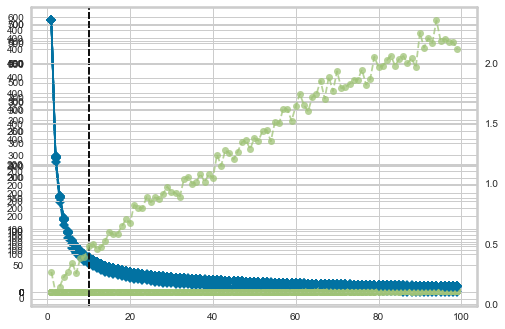

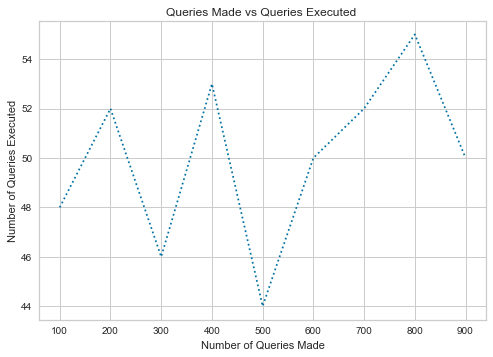

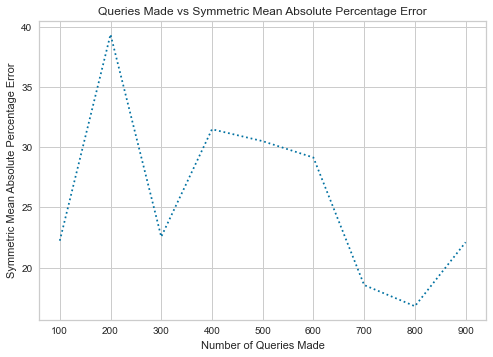

In [36]:
def main(cluster_data=cluster_data, kmeans=kmeans, data_points=data_points):
    x,y1, y2 = [], [], []
    num = 0
    count = 0
    excecutedQueries = 0
    predictions =[]
    labels = []
    queries_to_update = {'data':[], 'labels':[]}
    for query, label in zip(vd, vl):
        count+=1
        if shouldExecute(query):
            # Mocks execution and adds results to list
            excecutedQueries +=1
            queries_to_update['data'].append(query)
            queries_to_update['labels'].append(label)
        else:
            predictions.append(predict_query([query])[0])
            labels.append(label)
        num+=1
        if num == 100:
            print("Queries Executed: " +  str(excecutedQueries))
            y1.append(excecutedQueries)
            print("Symmetric Mean Absolute Percentage Error: "  + str(int(smape(np.array(labels), np.array(predictions)))) )
            y2.append(smape(np.array(labels), np.array(predictions)))
            x.append(count)

            cluster_data, kmeans, data_points = update_clusters(data_points, queries_to_update['data'], queries_to_update['labels'])
            num = 0
            excecutedQueries=0
            predictions =[]
            labels = []
    figg,axx = plt.subplots(1)
    axx.plot(x, y1, linestyle=':')

    plt.ylabel("Number of Queries Executed")
    plt.xlabel("Number of Queries Made")
    plt.title("Queries Made vs Queries Executed ")
    plt.show()    
#plt.plot(Year, Unemployment_Rate, color='red', marker='o')
    fig,ax = plt.subplots(1)
    ax.plot(x, y2, linestyle=':')

    plt.ylabel("Symmetric Mean Absolute Percentage Error")
    plt.xlabel("Number of Queries Made")
    plt.title("Queries Made vs Symmetric Mean Absolute Percentage Error")
    plt.show()

    
main(cluster_data=cluster_data, kmeans=kmeans, data_points=data_points)